# Build the SD network

In [1]:
using Revise, Plots, ArndtLabTheme, Graphs, DataFrames, IntervalTrees
using Statistics, CSV
pyplot()
theme(:arndtlab)

includet("../modules/modules_SDs.jl")

In [77]:
a = SDmoduleInit.Initialize_SD_object("../inputs/GRCh38GenomicSuperDup_sort.tab");
b = SDmoduleInit.Initialize_pyr_object(a.int_DF);
c, ind_arr, ind_arr2 = SDmoduleInit.Initialize_SD_object("../inputs/GRCh38GenomicSuperDup_sort.tab", comp3="filter");
size(b.int_DF)

(6791, 4)

In [78]:
# Generate the SD network

nex = deepcopy(b)
graph_obj = NetworkAnalysis.Initialize_SD_network(b, a.int_DF);
graph_obj.mg

"Double edges = 3703 = 0.2308315671362673 of all edges"

"Self loops = 269 = 0.040414663461538464 of all nodes (or 0.05940302896632848 without filtering singleton nodes)"

"Tandem edges = 1383 = 0.08621119561151976 of all edges and 0.30815508021390375 of all intra"

"Intra = 4488 and Inter = 11554 edges"

{6656, 16042} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [79]:
# Generate the SD network without "suspicious" borders (needed for future filtering)

graph_obj2 = NetworkAnalysis.Initialize_SD_network(nex, c.int_DF)
graph_obj2.mg

"Double edges = 2832 = 0.19540467812047196 of all edges"

"Self loops = 254 = 0.038161057692307696 of all nodes (or 0.05940302896632848 without filtering singleton nodes)"

"Tandem edges = 1305 = 0.09004346926102257 of all edges and 0.313475858755705 of all intra"

"Intra = 4163 and Inter = 10330 edges"

{6656, 14493} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

# Annotate SD network with genomic features

#### (!!!) Works only with additional input files:

#### 1) Additional UCSC annotation files (one can download them from the [UCSC Table Browser](https://genome.ucsc.edu/cgi-bin/hgTables));

#### 2) N files with duplicated regions coordinates randomly shuffled over the genome of interest. One can use "bedtools shuffle" command to generate these files. Example permutation files for GRCh38 are at /inputs/shuffle_infiles/.

#### One can skip this section and use the resulting annotatated duplicated regions. These files can be found at /outputs/annotated/ folder.

In [13]:
# Generate dfs of dulicated regions with shifted coordinates (by a border step).

border = 50

step_n_0 = deepcopy(b.int_DF)
step_n_100, step_n_200, step_n_300, step_n_400 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_100, step_p_200, step_p_300, step_p_400 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_500, step_p_600, step_p_700, step_p_800 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_900, step_p_1000, step_p_1100, step_p_1200 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_1300, step_p_1400, step_p_1500, step_p_1600 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_1700, step_p_1800, step_p_1900, step_p_2000 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_2100, step_p_2200, step_p_2300, step_p_2400 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_2500, step_p_2600, step_p_2700, step_p_2800 = deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF), deepcopy(b.int_DF)
step_p_2900, step_p_3000 = deepcopy(b.int_DF), deepcopy(b.int_DF);

steps = [step_n_0, step_n_100, step_n_200, step_n_300, step_n_400,
    step_p_100, step_p_200, step_p_300, step_p_400, step_p_500, step_p_600, step_p_700, step_p_800, step_p_900,
    step_p_1000, step_p_1100, step_p_1200, step_p_1300, step_p_1400, step_p_1500, step_p_1600, step_p_1700, step_p_1800, step_p_1900, 
    step_p_2000, step_p_2100, step_p_2200, step_p_2300, step_p_2400, step_p_2500, step_p_2600, step_p_2700, step_p_2800, step_p_2900, step_p_3000]

gaps = [-1*border, -2*border, -3*border, -4*border, -5*border, 
        1*border, 2*border, 3*border, 4*border, 5*border, 6*border, 7*border, 8*border, 9*border, 10*border,
        11*border, 12*border, 13*border, 14*border, 15*border, 16*border, 17*border, 18*border, 19*border, 20*border, 
        21*border, 22*border, 23*border, 24*border, 25*border, 26*border, 27*border, 28*border, 29*border, 30*border];

In [14]:
# Shuffle coordinates input files are needed. Example permutation files
# for GRCh38 are at inputs/shuffle_infiles/

steps_shuff, gaps_shuff = [], []

for i in 1:10    # better larger numbers of permutations. As for the test 10 is enough.
    name = "../inputs/shuffle_infiles/df_ws_jumps_shuff_"*string(i)*".csv"
    two = DataFrame(CSV.File(name))
    two[!, :chr] = string.(two[!, :chr])
    append!(steps_shuff, [deepcopy(two)])
    append!(gaps_shuff, 0)
end


In [15]:
# Read various USCS annotations
# These include: gene coordinates, assembly gaps, centromeres and telomeres coordinates,
# CpG islands coors., replication timing, recombination rates, CTCF sites, DNAse HS sites and repeats coordinates
# Takes some time to upload. One may use only a subset of annotations (please comment corresponding lines then).

using JLD2

genes_df = Annotate_SDs.Read_genes_and_gaps_2_DF("/home/abdullae/hossein/UCSC_features/genes_GRCh38_noprom_wsex.bed");
genes_tree = ApeLineage.Itree_from_DF_ape_lineage(genes_df, nothing);
genes_obj = SDmoduleInit.Interval_object(genes_df, genes_tree);

gaps_df = Annotate_SDs.Read_genes_and_gaps_2_DF("/home/abdullae/hossein/UCSC_features/hg38_assembly_all_gaps_wsex.bed");
gaps_tree = ApeLineage.Itree_from_DF_ape_lineage(gaps_df, nothing);
gaps_obj = SDmoduleInit.Interval_object(gaps_df, gaps_tree);

centro_df = Annotate_SDs.Read_genes_and_gaps_2_DF("/home/abdullae/hossein/UCSC_features/centromeres_hg38_wsex.txt");
telo_df = Annotate_SDs.Read_genes_and_gaps_2_DF("/home/abdullae/hossein/UCSC_features/telomeres_hg38_wsex.txt");

cpgisl_df = Annotate_SDs.Read_genes_and_gaps_2_DF("/home/abdullae/hossein/UCSC_features/CpG_islands_hg38_wsex.bed");
cpgisl_tree = ApeLineage.Itree_from_DF_ape_lineage(cpgisl_df, nothing);
cpgisl_obj = SDmoduleInit.Interval_object(cpgisl_df, cpgisl_tree);

repli_df = Annotate_SDs.Read_repli_recomb_dnase_2_DF("/home/abdullae/hossein/UCSC_features/Replit_GM12878_G1b1_hg38_wsex.bed");
repli_tree = ApeLineage.Itree_from_DF_ape_lineage(repli_df, :value);
repli_obj = SDmoduleInit.Interval_object(repli_df, repli_tree);

repli_deriv_df = Annotate_SDs.Read_repli_recomb_dnase_2_DF("/home/abdullae/hossein/UCSC_features/Replit_GM12878_G1b1_hg38_wsex.bed");
repli_deriv_tree = ApeLineage.Itree_from_DF_ape_lineage(repli_deriv_df, :value);
repli_deriv_obj = SDmoduleInit.Interval_object(repli_deriv_df, repli_deriv_tree);

ctcf_df = Annotate_SDs.Read_genes_and_gaps_2_DF("/home/abdullae/hossein/UCSC_features/CTCF_GM78_Ht1_hg38_wsex.bed");
ctcf_tree = ApeLineage.Itree_from_DF_ape_lineage(ctcf_df, nothing);
ctcf_obj = SDmoduleInit.Interval_object(ctcf_df, ctcf_tree);

recomb_df = Annotate_SDs.Read_repli_recomb_dnase_2_DF("/home/abdullae/hossein/UCSC_features/Recomb_rate_hg38_wsex.bed");
recomb_tree = ApeLineage.Itree_from_DF_ape_lineage(recomb_df, :value);
recomb_obj = SDmoduleInit.Interval_object(recomb_df, recomb_tree);

dnase_df = Annotate_SDs.Read_repli_recomb_dnase_2_DF("/home/abdullae/hossein/UCSC_features/DNAse_HS_master_hg38_wsex.bed");
dnase_tree = ApeLineage.Itree_from_DF_ape_lineage(dnase_df, :value);
dnase_obj = SDmoduleInit.Interval_object(dnase_df, dnase_tree);

repeats_df = Annotate_SDs.Read_repeats_2_DF("/home/abdullae/hossein/UCSC_features/Repeats_classes_hg38_wsex.bed");


In [16]:
GC_content = load("/home/abdullae/hossein/UCSC_features/dict_CG.jld2");
AT_content = load("/home/abdullae/hossein/UCSC_features/dict_AT.jld2");

In [17]:
# Adding annotation columns to all dfs

Annotate_SDs.add_all_columns!(b.int_DF)

for s in steps
    Annotate_SDs.add_all_columns!(s);
end

for s in steps_shuff
   Annotate_SDs.add_all_columns!(s) 
end

display(first(b.int_DF))


# Most of overalps with the genome annotation happens here (except repeats in the next cell).

Annotate_SDs.construct_DF!(b, a, :intra_frac);
Annotate_SDs.main_modification(b.int_DF, border, telo_df, centro_df, genes_obj, 
    cpgisl_obj, dnase_obj, recomb_obj, repli_obj, gaps_obj, ctcf_obj, repli_deriv_obj);
Annotate_SDs.modify_dfs_gaps!(b.int_DF, border, 0, cpgisl_obj, dnase_obj, recomb_obj, repli_obj, gaps_obj, ctcf_obj, repli_deriv_obj);
display(first(b.int_DF))

Annotate_SDs.finzalize_df_cols!(steps, b, border, gaps, telo_df, centro_df, genes_obj,
    cpgisl_obj, dnase_obj, recomb_obj, repli_obj, gaps_obj, ctcf_obj, repli_deriv_obj)

display("Now shuffs:")
display(first(steps_shuff[1]))
Annotate_SDs.finzalize_df_cols!(steps_shuff, b, border, gaps_shuff, telo_df, centro_df, genes_obj, 
    cpgisl_obj, dnase_obj, recomb_obj, repli_obj, gaps_obj, ctcf_obj, repli_deriv_obj)
display(first(steps_shuff[1]))

Row,chr,coor_s,coor_e,ids,length,centro,telo,gaps,genes,intra_frac,cpgisl_in,cpgisl_bor,ctcf,repli_in,repli_bor,repli_bor_deriv,repli_deriv,repli_vari,recomb_in,recomb_bor,dnase_in,dnase_bor
,String,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,10000,207666,id1,197666,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Row,chr,coor_s,coor_e,ids,length,centro,telo,gaps,genes,intra_frac,cpgisl_in,cpgisl_bor,ctcf,repli_in,repli_bor,repli_bor_deriv,repli_deriv,repli_vari,recomb_in,recomb_bor,dnase_in,dnase_bor
,String,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,10000,207666,id1,197666,121818793,0,2,6,0.206,3,0,0,23.697,21.098,0.0,31.0,12.717,1.306,1.306,18.837,39.412


52.65823984146118

"Now shuffs:"

Row,chr,coor_s,coor_e,ids,length,centro,telo,gaps,genes,intra_frac,cpgisl_in,cpgisl_bor,ctcf,repli_in,repli_bor,repli_bor_deriv,repli_deriv,repli_vari,recomb_in,recomb_bor,dnase_in,dnase_bor
,String,Int64,Int64,String7,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,158038534,158236200,id1,197666,0,0,0,0,0.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


12.238089084625244

Row,chr,coor_s,coor_e,ids,length,centro,telo,gaps,genes,intra_frac,cpgisl_in,cpgisl_bor,ctcf,repli_in,repli_bor,repli_bor_deriv,repli_deriv,repli_vari,recomb_in,recomb_bor,dnase_in,dnase_bor
,String,Int64,Int64,String7,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2,158038534,158236200,id1,197666,63947977,83947329,0,3,0.206,0,0,0,5.201,6.0,10.0,9.0,2.486,0.83,0.83,47.384,38.134


In [18]:
# Repeats annotation part (may take long on the local computer)

Annotate_SDs.go_thru_thru!(b.int_DF, repeats_df, border, 0);
display("main object annotation is over")

for (i, s) in enumerate(steps)
    Annotate_SDs.go_thru_thru!(s, repeats_df, border, gaps[i]);
end
display("shifted dfs annotation is over")

for (i, s) in enumerate(steps_shuff)
   Annotate_SDs.go_thru_thru!(s, repeats_df, border, gaps_shuff[i])
end
display("shuffled dfs annotation is over")


6.71415114402771

"main object annotation is over"

2.4523050785064697

2.2970969676971436

2.227294921875

2.356985092163086

2.332606077194214

2.3264689445495605

2.310081958770752

2.3924779891967773

2.3541858196258545

2.3981010913848877

2.373189926147461

2.3999171257019043

2.427119016647339

2.3377761840820312

3.498414993286133

7.734750986099243

2.2756521701812744

2.2244350910186768

2.266324043273926

2.273190975189209

2.2135519981384277

2.2098779678344727

2.2212162017822266

2.2928659915924072

2.3021798133850098

2.3288910388946533

2.241556167602539

2.344196081161499

2.2596089839935303

2.218229055404663

2.2391059398651123

2.263798952102661

2.296830892562866

2.3091211318969727

3.31833815574646

"shifted dfs annotation is over"

7.007169961929321

2.324997901916504

2.327364921569824

2.326897144317627

2.3165979385375977

2.3305342197418213

2.285390853881836

2.270267963409424

2.290442943572998

2.242563009262085

"shuffled dfs annotation is over"

In [19]:
# Adds information on G/C content

Annotate_SDs.GC_flanks_measure!(b.int_DF, GC_content, AT_content)

for (i, s) in enumerate(steps)
    Annotate_SDs.GC_flanks_measure!(s, GC_content, AT_content)
end

for (i, s) in enumerate(steps_shuff)
    Annotate_SDs.GC_flanks_measure!(s, GC_content, AT_content);
end
display("done")

"done"

In [20]:
rep_obj, recomb_obj, dnase_obj, genes_obj = nothing, nothing, nothing, nothing;
gaps_obj, cpgisl_obj, ctcf_obj = nothing, nothing, nothing;
repli_deriv_obj, AT_content, GC_content = nothing, nothing, nothing;

In [20]:
show(first(b.int_DF, 3), allcols=true)

3×67 DataFrame
 Row │ chr     coor_s  coor_e  ids     length  centro     telo    gaps   genes  intra_frac  cpgisl_in  cpgisl_bor  ctcf   repli_in  repli_bor  repli_bor_deriv  repli_deriv  repli_vari  recomb_in  recomb_bor  dnase_in  dnase_bor  DNA_l  LINE_l  LTR_l  SINE_l  Low_complexity_l  Retroposon_l  Satellite_l  Simple_repeat_l  rRNA_l  snRNA_l  scRNA_l  srpRNA_l  tRNA_l  RC_l   DNA_r  LINE_r  LTR_r  SINE_r  Low_complexity_r  Retroposon_r  Satellite_r  Simple_repeat_r  rRNA_r  snRNA_r  scRNA_r  srpRNA_r  tRNA_r  RC_r   L1_s_l  L2_s_l  MIR_s_l  Alu_s_l  Satellite_s_l  L1_s_r  L2_s_r  MIR_s_r  Alu_s_r  Satellite_s_r  used_coor_l_s  used_coor_l_e  used_coor_r_s  used_coor_r_e  CG_frac_l  CG_frac_r  CG_frac_in 
     │ String  Int64   Int64   String  Int64   Int64      Int64   Int64  Int64  Float64     Int64      Int64       Int64  Float64   Float64    Float64          Float64      Float64     Float64    Float64     Float64   Float64    Int64  Int64   Int64  Int64   Int64             I

In [21]:
# save results in the csv format

using CSV

for (i, s) in enumerate(steps)
    q = gaps[i]
    CSV.write("../outputs/annotated/out_df_ws_jumps$q.csv", s)
end

for (i, s) in enumerate(steps_shuff)
    CSV.write("../outputs/annotated/out_df_shuff_$i.csv", s)
end

In [21]:
3-2

1

# Build the MST of dupications + Sharp borders test

In [22]:
# Weights assignment. Weights are proportional to the percantage of shared edges.
# For test reasons one may assign weights and shuffle them.

MST_from_SD.assign_weights_edges!(graph_obj.mg, comp="normal_noise");
MST_from_SD.assign_weights_edges!(graph_obj2.mg, comp="normal_noise");
#assign_weights_edges!(graph_obj2.mg, "shuffle");
display("done")

"done"

In [23]:
# Finding the MST of primary duplications

n_deg, ids_hui, edg_lis = MST_from_SD.graph_nosec_from_graph(graph_obj.mg, comp="mst_krus")
b.int_DF[!, :jumps] = zeros(Int64, size(b.int_DF)[1])

for (i, val) in enumerate(ids_hui)
    b.int_DF[b.int_DF[!,:ids] .== val, :jumps] .= n_deg[i] 
end


0.0876736111111111

"percantage of random permutations with less sharp borders:"

0.0

0.08072289156626505

"percantage of random permutations with less sharp borders:"

0.0

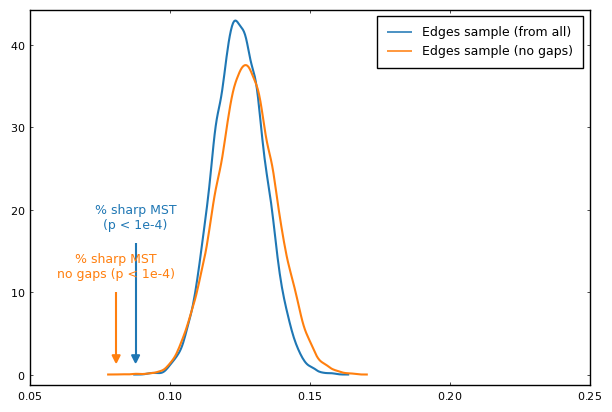

In [24]:
# This cell checks sharp borders distribution in the MST and random samples of edges
# all edges of the giant component are analyzed + only those without assembly gaps at flanks

using Distributions, StatsPlots

p = plot(xlims = (0.05, 0.25), legendfont=font(9))
val, out_lis = MST_from_SD.test_sharpness_distribution(graph_obj.mg, graph_obj2.mg,
    edg_lis, 10000, "sharp edges");
density!(p, out_lis, label="Edges sample (from all)", show=true, color=1, grid=false);
plot!(p, [val, val], [16.0, 1.5], arrow=arrow(:closed, 0.5), color=1, label=false);
annotate!([val], [19.0], text("% sharp MST\n(p < 1e-4)", ArndtLabTheme.arndtlab_palette[1], :center, 9));

ids_sharp = b.int_DF[b.int_DF[!, "gaps"] .!= 0.0, "ids"]
val, out_lis = MST_from_SD.test_sharpness_distribution(graph_obj.mg, graph_obj2.mg,
    edg_lis, 10000, "sharp edges"; nodes_out=ids_sharp);
density!(p, out_lis, label="Edges sample (no gaps)", show=true, color=2, grid=false);
plot!(p, [val, val], [10.0, 1.5], arrow=arrow(:closed, 0.5), color=2, label=false);
annotate!([val], [13.0], text("% sharp MST\nno gaps (p < 1e-4)", ArndtLabTheme.arndtlab_palette[2], :center, 9));


0.032639038007300836

"percantage of random permutations with higher fraction of hihgh identity edges:"

0.009399999999999964

0.02585604472396925

"percantage of random permutations with higher fraction of hihgh identity edges:"

0.0

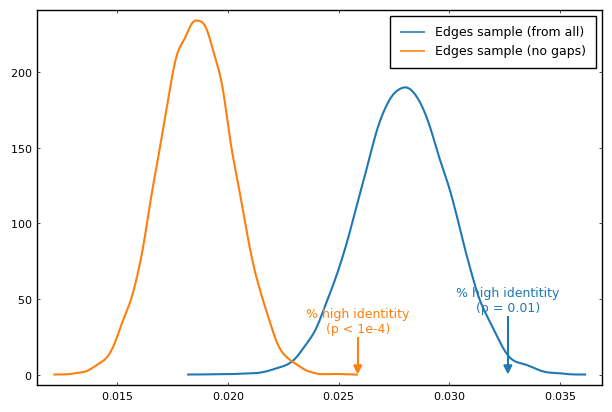

In [382]:
p = plot(legendfont=font(9))
val, out_lis = MST_from_SD.test_sharpness_distribution(graph_obj.mg, graph_obj2.mg,
    edg_lis, 10000, "identity"; edges_ident=graph_obj.edges_ident);
density!(p, out_lis, label="Edges sample (from all)", show=true, color=1, grid=false);
plot!(p, [val, val], [39.0, 1.5], arrow=arrow(:closed, 0.5), color=1, label=false);
annotate!([val], [49.0], text("% high identitity\n(p = 0.01)", ArndtLabTheme.arndtlab_palette[1], :center, 9));

val, out_lis = MST_from_SD.test_sharpness_distribution(graph_obj.mg, graph_obj2.mg,
    edg_lis, 10000, "identity"; edges_ident=graph_obj.edges_ident, nodes_out=ids_sharp);
density!(p, out_lis, label="Edges sample (no gaps)", show=true, color=2, grid=false);
plot!(p, [val, val], [25.0, 1.5], arrow=arrow(:closed, 0.5), color=2, label=false);
annotate!([val], [35.0], text("% high identitity\n(p < 1e-4)", ArndtLabTheme.arndtlab_palette[2], :center, 9));


In [25]:
# Reassign weights in order to redo MST search. Now we set the weights
# such that it is highly unlikely to go through the sharp ("suspicious") edges without assembly gaps
# Then do find MST => number of jumps for each duplicated region

using MetaGraphs

dif = collect(edges(difference(graph_obj.mg, graph_obj2.mg)))
display(length(dif))
ids = b.int_DF[b.int_DF[!, "gaps"] .> 0.0, "ids"]

suspicious_edges = []
for e in dif
    if !((get_prop(graph_obj.mg, e.src, :id) in ids) | (get_prop(graph_obj.mg, e.dst, :id) in ids))
        append!(suspicious_edges, [e])
    end
end
display(length(suspicious_edges))

N = 10
b.int_DF[!, :jumps] = zeros(Float64, size(b.int_DF)[1])
for i in 1:N
    MST_from_SD.assign_weights_edges!(graph_obj.mg, comp="sharp_out", suspicious_edges=suspicious_edges);
    n_deg, ids_hui, edg_lis = MST_from_SD.graph_nosec_from_graph(graph_obj.mg, comp="mst_krus")
    for (i, val) in enumerate(ids_hui)
        b.int_DF[b.int_DF[!,:ids] .== val, :jumps] .+= n_deg[i]
    end
end

b.int_DF[!, :jumps] = round.(b.int_DF[!, :jumps]/N);

1549

1035

In [26]:
b.int_DF[!, ["chr", "coor_s", "coor_e", "ids", "length", "gaps"]]

Row,chr,coor_s,coor_e,ids,length,gaps
,String,Int64,Int64,String,Int64,Int64
1,1,10000,207666,id1,197666,2
2,1,257666,297956,id2,40290,2
3,1,347968,535988,id3,188020,2
4,1,585988,817292,id4,231304,1
5,1,817367,821400,id5,4033,0
6,1,823659,867135,id6,43476,0
7,1,867192,872507,id7,5315,0
8,1,872879,898701,id8,25822,0
9,1,955921,960557,id9,4636,0


In [25]:
# Uncomment to save the resulting file

using CSV

CSV.write("../outputs/annotated/out_df_ws_jumps.csv", b.int_DF)

"../outputs/annotated/out_df_ws_jumps.csv"

# Test the MST algorithm on PCM simulated networks

In [31]:
# The function with the PCM growth model + additional processes of edges loss and a gene conversion

using StatsBase, Distributions, Random, MetaGraphs

function copy_model_bigcomp(N::Int64, frac::Float64, degrad_rate::Float64, gc_rate::Float64; seed::Int64=42)
    Random.seed!(seed)
    d = Normal(degrad_rate, degrad_rate/2)
    edg_copy::Array{Graphs.SimpleGraphs.SimpleEdge{Int64},1} = []
    gr = MetaGraph(complete_graph(2), 1.0)
    append!(edg_copy, [Edge(1, 2)])
    A = zeros(Float64, 2, 2)
    A[1, 2], A[2, 1] = 1.0, 1.0
    num_del_edges, num_gc_edges = 0, 0
    i = 0
    while nv(gr) - length(filter(x -> length(neighbors(gr, x)) == 0, vertices(gr))) < N
        i += 1
        A = [A zeros(size(A)[1], 1)]
        A = [A; zeros(1, size(A)[2])]
        weis = Weights(map(x -> neighbors(gr, x) |> length, vertices(gr)))
        m_node = StatsBase.sample(vertices(gr), weis)
        add_vertex!(gr)
        for nei in neighbors(gr, m_node)
            if rand() < frac
                add_edge!(gr, nei, i+2)
                A[nei, i+2], A[i+2, nei] = A[nei, m_node], A[nei, m_node]
           end
        end
        add_edge!(gr, m_node, i+2)
        A[m_node, i+2], A[i+2, m_node] = 1.0, 1.0
        append!(edg_copy, [Edge(m_node, i+2)])
        if degrad_rate > 0.0
            B = rand(d, size(A)[1], size(A)[2])
            B[B .<= 0.0] .= 0.0
            for e in findall(x -> x > 0.0, (A .- B .< 0.9) .& (A .> 0.9))
                rem_edge!(gr, e[1], e[2])
                num_del_edges += 1
            end
            A = A .- B
            A[A .< 0.9] .= 0.0
            inds_edges = findall(x -> x > 0.0, (A .> 0.9))
            num = trunc(Int, length(inds_edges)*gc_rate)
            gc_edges = StatsBase.sample(inds_edges, Weights(ones(length(inds_edges))), num; replace=false)
            for e in gc_edges
                A[e[1], e[2]], A[e[2], e[1]] = 1.0, 1.0
                num_gc_edges += 1
            end
        end
    end
    return gr, edg_copy
end


copy_model_bigcomp (generic function with 1 method)

In [69]:
# Run network growth once + compare all primary edges reconstruction strategies
# f = 0.37 to make the number of edges proporional to the giamnt component of the original SD network
# loss of identity rate = 7.5e-5. This value is set such that ~5% bases are mutated at the end. So that:
# All effected bases = 0.000075*L*(1325+1)*1325/2, where L is an average SD length.
# Per base probability of being affectd = 0.000075*(1325+1)/2 = 0.05.
# gene conversion rate is equal to 3e-4. It leads to ~33% of edges being affected by IGC during the network growth.

copy_gr, edg_copy_real = copy_model_bigcomp(1325, 0.37, 0.000075, 0.0003)
MST_from_SD.wrapper_MST(copy_gr, edg_copy_real; verbose=true, meanover=10);

Fraction of edges match (MST Kruskal):0.620845921450151
Fraction of edges match (Random MST):0.1472809667673716
Variance explained for MST Kruskal:0.7144103326018613
Variance explained for Random MST:0.415400082338984
Variance explained for Simple:0.5441692846217567
Variance explained for PageRank:0.5991799712984469


In [33]:
MST_from_SD.wrapper_MST(copy_gr, edg_copy_real; verbose=true, meanover=1);

Fraction of edges match (MST Kruskal):0.6268882175226587
Fraction of edges match (Random MST):0.14954682779456194
Variance explained for MST Kruskal:0.6915141642655762
Variance explained for Random MST:0.3064625352674118
Variance explained for Simple:0.5441692846217567
Variance explained for PageRank:0.5991799712984469


In [170]:
# Calculate final values:

arr_res = reshape([], 0, 6)

for i in 1:10 # Better use 100 iterations, but will take several hours
    copy_gr, edg_copy_real = copy_model_bigcomp(1325, 0.37, 0.000075, 0.0003; seed=i)
    arr_res = cat(dims=1, arr_res, MST_from_SD.wrapper_MST(copy_gr, edg_copy_real; verbose=false, meanover=10))
end

ms = mean(arr_res, dims=1)
labs = ["Fraction of edges match (MST Kruskal)", "Fraction of edges match (Random MST)",
        "Variance explained for MST Kruskal", "Variance explained for Random MST",
        "Variance explained for Simple", "Variance explained for PageRank"]

for i in 1:6
    display("$(labs[i]): $(ms[i])")
end

"Fraction of edges match (MST Kruskal): 0.6213746223564954"

"Fraction of edges match (Random MST): 0.13481873111782477"

"Variance explained for MST Kruskal: 0.6702916386791735"

"Variance explained for Random MST: 0.33175345504365555"

"Variance explained for Simple: 0.5196971974673189"

"Variance explained for PageRank: 0.5543950170268876"

In [82]:
5-3

2